# Transcriptome-Wide Association Study (TWAS) using High-dimensional Regression Methods

This notebook demonstrates how to perform Transcriptome-Wide Association Studies (TWAS) using weights derived from various high-dimensional regression methods including SuSiE, mvSuSiE and mr.mash. TWAS integrates eQTL data with GWAS summary statistics to identify gene-trait associations. The key idea is that if genetic variants affect both gene expression (eQTL effects) and trait (GWAS effects), we can aggregate these effects using learned weights from expression data to test for gene-trait associations.

For details on high-dimensional regression methods used to obtain weights, please refer to:
- `finemapping.ipynb`
- `multivariate_finemapping.ipynb`
- `mr_mash.ipynb`

Although we simulate expression data in 5 tissues to demonstrate multivariate methods capabilities, for simplicity in this TWAS exercise we will focus on using weights from the first tissue context to perform TWAS test.

In [1]:
library(susieR)
library(mvsusieR)
library(mr.mash.alpha)
set.seed(1)

Loading required package: mashr

Loading required package: ashr



## TWAS Test Definition

The goal of this exercise is to demonstrate how to compute TWAS (Transcriptome-Wide Association Study) test statistics using weights learned from various high-dimensional regression methods. Before we proceed with model fitting, we first introduce the TWAS test statistic.

The TWAS test combines eQTL weights with GWAS z-scores to compute a gene-level association statistic. The test statistic is computed as:

$$Z_{\text{TWAS}} = \frac{w^T z}{\sqrt{w^T R w}}$$

where $w$ is the vector of weights, $z$ is the vector of GWAS z-scores, and $R$ is the LD matrix. This is implemented in the following function:

In [2]:
twas_z <- function(weights, z, R = NULL, X = NULL) {
  if (length(weights) != length(z)) {
    stop("Weights and z-scores must have the same length.")
  }
  if (is.null(R)) R <- cor(X)
  stat <- t(weights) %*% z
  denom <- t(weights) %*% R %*% weights
  zscore <- stat / sqrt(denom)
  pval <- pchisq(zscore * zscore, 1, lower.tail = FALSE)
  return(list(z = zscore, pval = pval))
}

## Simulate molecular trait data

We'll use the same simulation setup as in the mr.mash tutorial, simulating expression of a gene across 5 tissues:

In [3]:
dat <- simulate_mr_mash_data(n = 300, p = 500, p_causal = 3, r = 5, pve = 0.25, V_cor = 0.25)
# Split into training and test sets
ntest <- 50
Ytrain <- dat$Y[-(1:ntest),]
Xtrain <- dat$X[-(1:ntest),]
Ytest <- dat$Y[1:ntest,]
Xtest <- dat$X[1:ntest,]

## Obtain weights from different methods

First, let's fit univariate SuSiE using the first tissue:

In [4]:
fit_susie <- susie(Xtrain, Ytrain[,1], L=10)

Next, we'll fit mr.mash, which will also provide residual variance estimates:

In [5]:
# Fit mr.mash
S0 <- compute_canonical_covs(r=5, singletons=TRUE, hetgrid=seq(0,1,0.25))
univ_sumstats <- compute_univariate_sumstats(Xtrain, Ytrain, standardize=TRUE)
scaling_grid <- autoselect.mixsd(univ_sumstats, mult=sqrt(2))^2
S0 <- expand_covs(S0, scaling_grid)
fit_mrmash <- mr.mash(X=Xtrain, Y=Ytrain, S0=S0)

Processing the inputs... Done!
Fitting the optimization algorithm using 2 RcppParallel threads... 
 iter    mu1_max.diff     ELBO_diff               ELBO
   1       2.02e-01            Inf      -1.49086924741276698114e+03
   2       7.20e-02       1.78e+02      -1.31326485382569012472e+03
   3       1.42e-02       3.46e+01      -1.27864561842736475228e+03
   4       5.67e-03       1.26e+01      -1.26602106910475140467e+03
   5       3.23e-03       6.18e+00      -1.25983909326708430854e+03
   6       2.14e-03       3.65e+00      -1.25619172558731656864e+03
   7       1.58e-03       2.40e+00      -1.25379032230643292678e+03
   8       1.22e-03       1.70e+00      -1.25209372777673706878e+03
   9       9.75e-04       1.26e+00      -1.25083377432441670862e+03
  10       7.99e-04       9.72e-01      -1.24986221513326358945e+03
  11       6.68e-04       7.72e-01      -1.24909053185505581496e+03
  12       5.67e-04       6.28e-01      -1.24846273883333651611e+03
  13       4.88e-04       5.21

Finally, we'll fit mvSuSiE using uniform mixture weights and canonical covariance matrices `S0`, removing the first component in `S0` which is the "null" effect. Note that for the residual variance, we can either use the estimate from mr.mash fit (as shown here) or directly use the covariance of Y. For prior specification, more sophisticated approaches exist, particularly the multivariate adaptive shrinkage (mash) model (Urbut et al. 2019, Nature Genetics) which can learn complex patterns of effect sharing across tissues.

In [6]:
# Get uniform weights
n_comp <- length(S0[-1])
w0 <- rep(1/n_comp, n_comp)

# Create prior
prior <- create_mixture_prior(list(matrices = S0[-1],
                                  weights = w0),
                              null_weight = 0)

# Fit mvSuSiE using mr.mash residual variance
fit_mvsusie <- mvsusie(Xtrain, Ytrain, standardize = TRUE,
                       prior_variance = prior,
                       residual_variance = fit_mrmash$V,
                       estimate_prior_variance = TRUE)

Initializing data object...

Dimension of X matrix: 250 500

Dimension of Y matrix: 250 5

Initializing prior object ...

Number of components in the mixture prior: 161

Running IBSS algorithm...

Iteration 1 delta = Inf

Iteration 2 delta = 12.5061971197028

Iteration 3 delta = 3.04508433810247

Iteration 4 delta = 0.186915951605442

Iteration 5 delta = 0.15480860654111

Iteration 6 delta = 0.13883133079753

Iteration 7 delta = 0.126592787563141

Iteration 8 delta = 0.116838226733762

Iteration 9 delta = 0.108810018695294

Iteration 10 delta = 0.102030740262762

Iteration 11 delta = 0.0966023101877909

Iteration 12 delta = 2.18986830714834

Iteration 13 delta = 0.0151529720164945

Iteration 14 delta = 0.0134660025412359

Iteration 15 delta = 0.0120485658096641

Iteration 16 delta = 0.0108467097741141

Iteration 17 delta = 0.00981860605679685

Iteration 18 delta = 0.008931784735978

Iteration 19 delta = 0.00816096722837756

Iteration 20 delta = 0.00748643877500399

Iteration 21 delta =

## Extract and compare weights

Let's visualize the weights (coefficients) from different methods for the first tissue:

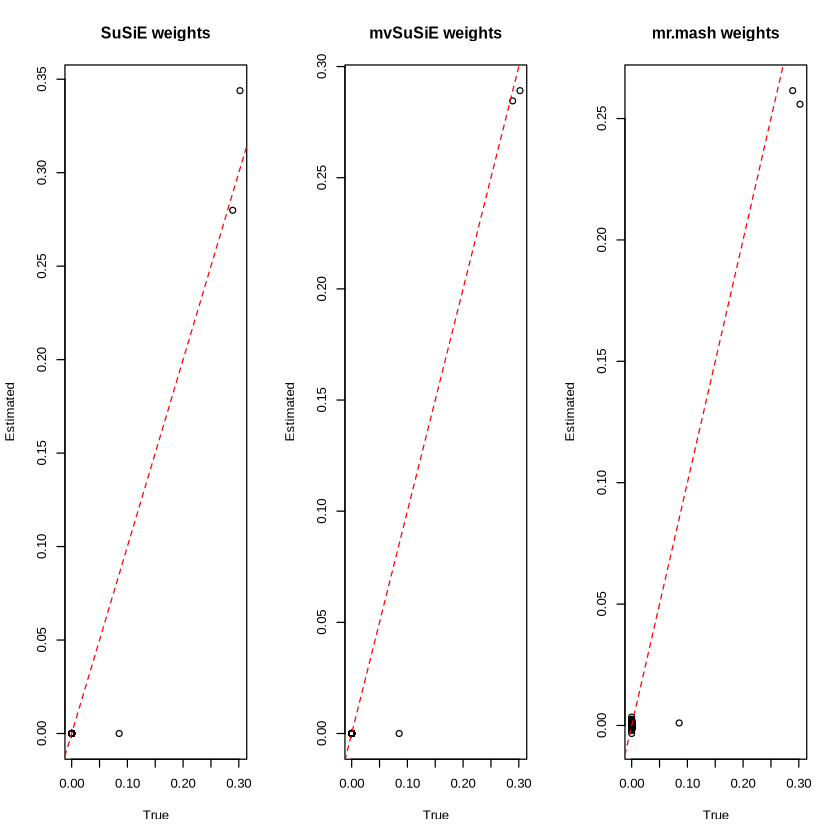

In [7]:
par(mfrow=c(1,3))
plot(dat$B[,1], coef(fit_susie)[-1], main="SuSiE weights", 
     xlab="True", ylab="Estimated")
abline(0,1,col='red',lty=2)

plot(dat$B[,1], coef(fit_mvsusie)[,1][-1], 
     main="mvSuSiE weights", xlab="True", ylab="Estimated")
abline(0,1,col='red',lty=2)

plot(dat$B[,1], fit_mrmash$mu1[,1], 
     main="mr.mash weights", xlab="True", ylab="Estimated")
abline(0,1,col='red',lty=2)

It seems all the 3 methods perform similarly, correctly captured two out of the 3 simulated effects.

## Simulate GWAS z-scores

We'll simulate GWAS z-scores taking into account the LD structure (R). The z-scores are generated under the assumption that variants affecting gene expression in the first tissue also affect the trait with correlated effect sizes:

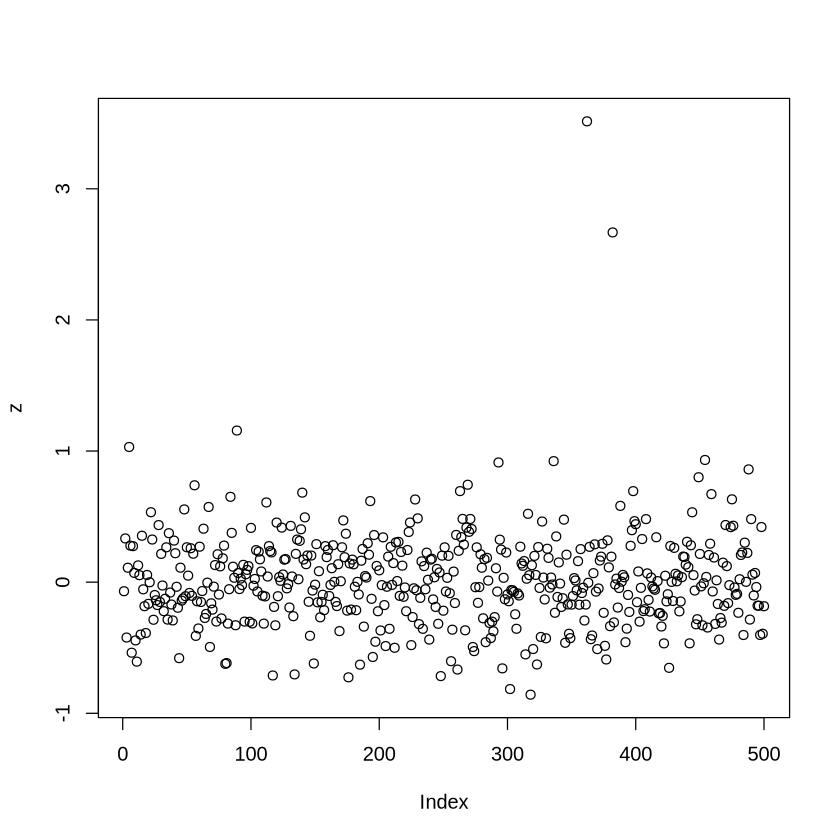

In [8]:
# Compute LD matrix
R <- cor(Xtrain)
# Simulate z-scores
set.seed(1)
true_effects <- sign(dat$B[,1]) * rnorm(length(dat$B[,1]), sd=3)
z <- R %*% true_effects
plot(z)

## Perform TWAS

Let's perform TWAS using weights from each method focusing on the first tissue:

In [9]:
# Compute TWAS results using different weights
twas_susie <- twas_z(coef(fit_susie)[-1], z, R)
twas_mvsusie <- twas_z(coef(fit_mvsusie)[,1][-1], z, R)
twas_mrmash <- twas_z(fit_mrmash$mu1[,1], z, R)

# Display results
results <- data.frame(
  Method = c("SuSiE", "mvSuSiE", "mr.mash"),
  Z_score = c(twas_susie$z, twas_mvsusie$z, twas_mrmash$z),
  P_value = c(twas_susie$pval, twas_mvsusie$pval, twas_mrmash$pval)
)
print(results)

   Method  Z_score      P_value
1   SuSiE 4.643458 3.426258e-06
2 mvSuSiE 4.737701 2.161567e-06
3 mr.mash 4.748785 2.046424e-06


## Computing TWAS weights using additional regression methods

The `pecotmr` package (https://github.com/cumc/pecotmr/) provides a unified interface for computing TWAS weights using various high-dimensional regression methods. Here's how to use them:


In [10]:
library(pecotmr)


Attaching package: ‘pecotmr’


The following object is masked _by_ ‘.GlobalEnv’:

    twas_z




In [11]:
# Create a character vector of weight methods to use
# Each method corresponds to a `*_weights()` function in pecotmr
w_methods <- c("susie_weights", "enet_weights", "lasso_weights", "mrash_weights", 
            "bayes_n_weights", "bayes_l_weights", "bayes_a_weights", 
            "bayes_c_weights", "bayes_r_weights")

# Compute weights using all methods
# Only using the first tissue for demonstration
weights <- twas_weights(Xtrain, Ytrain[,1], 
                       weight_methods = w_methods)

Total time elapsed for susie_wrapper: 0.0850000000000009



Mr.ASH terminated at iteration 346.


Type of analysis performed: st-blr-individual-level-dense-ld

Type of analysis performed: st-blr-individual-level-dense-ld

Type of analysis performed: st-blr-individual-level-dense-ld

Type of analysis performed: st-blr-individual-level-dense-ld

Type of analysis performed: st-blr-individual-level-dense-ld



Vasualize weights from different methods against true effects,

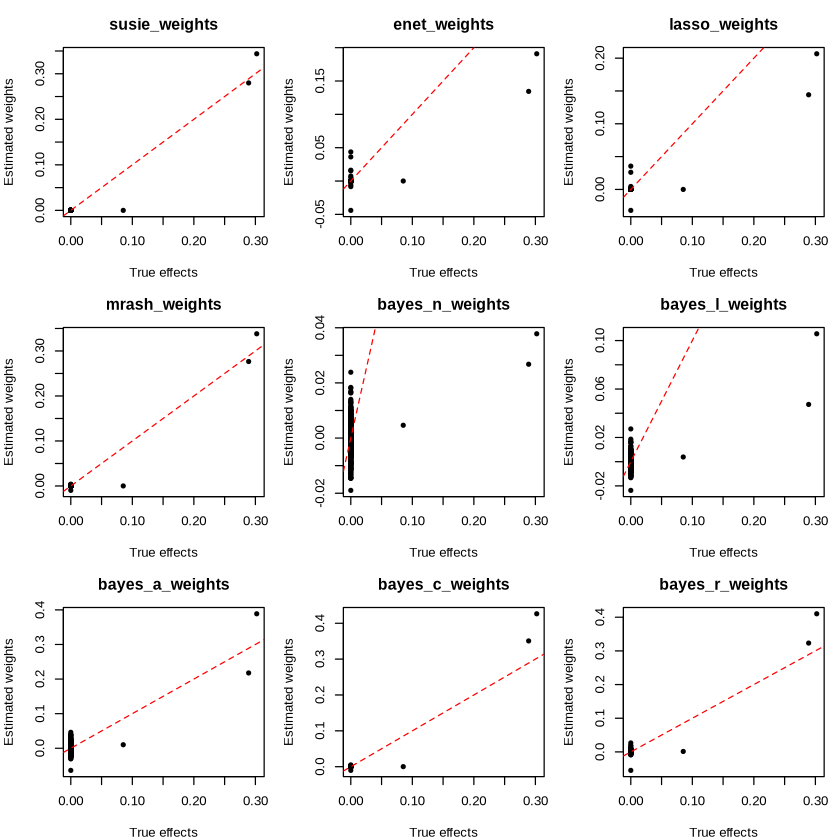

In [12]:
par(mfrow = c(3,3), mar = c(4,4,3,1))
for (method in w_methods) {
  plot(dat$B[,1], weights[[method]], 
       main = method,
       xlab = "True effects", 
       ylab = "Estimated weights",
       pch = 20)
  abline(0, 1, col = 'red', lty = 2)
}

Performance of these method can be assessed using cross validation as one way to select the best model for TWAS test,

In [13]:
weights_cv <- twas_weights_cv(Xtrain, Ytrain[,1], 
                       weight_methods = w_methods, fold = 5)

Y converted to matrix of 250 rows and 1 columns.

0 out of 500 total variants dropped due to quality control on X matrix.

Additional 0 variants dropped after considering missing data in Y matrix, with 500 variants left.

Total time elapsed for susie_wrapper: 0.117000000000004



Mr.ASH terminated at iteration 443.


Type of analysis performed: st-blr-individual-level-dense-ld

Type of analysis performed: st-blr-individual-level-dense-ld

Type of analysis performed: st-blr-individual-level-dense-ld

Type of analysis performed: st-blr-individual-level-dense-ld

Type of analysis performed: st-blr-individual-level-dense-ld

0 out of 500 total variants dropped due to quality control on X matrix.

Additional 0 variants dropped after considering missing data in Y matrix, with 500 variants left.

Total time elapsed for susie_wrapper: 0.0649999999999977



Mr.ASH terminated at iteration 357.


Type of analysis performed: st-blr-individual-level-dense-ld

Type of analysis performed: st-blr-individual-level-dense-ld

Type of analysis performed: st-blr-individual-level-dense-ld

Type of analysis performed: st-blr-individual-level-dense-ld

Type of analysis performed: st-blr-individual-level-dense-ld

0 out of 500 total variants dropped due to quality control on X matrix.

Additional 0 variants dropped after considering missing data in Y matrix, with 500 variants left.

Total time elapsed for susie_wrapper: 0.0519999999999925



Mr.ASH terminated at iteration 556.


Type of analysis performed: st-blr-individual-level-dense-ld

Type of analysis performed: st-blr-individual-level-dense-ld

Type of analysis performed: st-blr-individual-level-dense-ld

Type of analysis performed: st-blr-individual-level-dense-ld

Type of analysis performed: st-blr-individual-level-dense-ld

0 out of 500 total variants dropped due to quality control on X matrix.

Additional 0 variants dropped after considering missing data in Y matrix, with 500 variants left.

Total time elapsed for susie_wrapper: 0.0649999999999977



Mr.ASH terminated at iteration 364.


Type of analysis performed: st-blr-individual-level-dense-ld

Type of analysis performed: st-blr-individual-level-dense-ld

Type of analysis performed: st-blr-individual-level-dense-ld

Type of analysis performed: st-blr-individual-level-dense-ld

Type of analysis performed: st-blr-individual-level-dense-ld

0 out of 500 total variants dropped due to quality control on X matrix.

Additional 0 variants dropped after considering missing data in Y matrix, with 500 variants left.

Total time elapsed for susie_wrapper: 0.054000000000002



Mr.ASH terminated at iteration 472.


Type of analysis performed: st-blr-individual-level-dense-ld

Type of analysis performed: st-blr-individual-level-dense-ld

Type of analysis performed: st-blr-individual-level-dense-ld

Type of analysis performed: st-blr-individual-level-dense-ld

Type of analysis performed: st-blr-individual-level-dense-ld



In [14]:
weights_cv$performance

,corr,rsq,adj_rsq,pval,RMSE,MAE
context_1,0.4974325,0.2474391,0.2444046,4.938229e-17,1.245811,1.06505
,corr,rsq,adj_rsq,pval,RMSE,MAE
context_1,0.462199,0.2136279,0.210457,1.233548e-14,1.259324,1.071705
,corr,rsq,adj_rsq,pval,RMSE,MAE
context_1,0.4666951,0.2178043,0.2146503,6.314326e-15,1.257297,1.0714
,corr,rsq,adj_rsq,pval,RMSE,MAE
context_1,0.4933093,0.243354,0.2403031,9.741127e-17,1.247401,1.066367
,corr,rsq,adj_rsq,pval,RMSE,MAE
context_1,0.1191553,0.01419799,0.01022298,0.05993429,1.297954,1.097228
,corr,rsq,adj_rsq,pval,RMSE,MAE


Based on cross validation performance the best model for this data-set is SuSiE, followed by BayesC. This is not suprising considering how the data was simulated (why?).

Finally we demonstrate TWAS test using weights from each method,

In [15]:
twas_results <- data.frame(
  Method = w_methods,
  Z_score = NA,
  P_value = NA
)

for (i in seq_along(w_methods)) {
  method <- w_methods[i]
  res <- twas_z(weights[[method]], z, R)
  twas_results$Z_score[i] <- res$z
  twas_results$P_value[i] <- res$pval
}

print(twas_results)

           Method  Z_score      P_value
1   susie_weights 4.643458 3.426258e-06
2    enet_weights 4.379759 1.188107e-05
3   lasso_weights 4.467725 7.905587e-06
4   mrash_weights 4.649285 3.330881e-06
5 bayes_n_weights 2.868538 4.123738e-03
6 bayes_l_weights 3.355518 7.921664e-04
7 bayes_a_weights 3.631836 2.814121e-04
8 bayes_c_weights 4.652555 3.278471e-06
9 bayes_r_weights 4.579618 4.658250e-06
